# <center>Starbuck Capstone Project 

<center> <font size = 4>Zhizhen Chen June 2024</center>

## Background Introduction
The data for this exercise consists of about 120,000 Starbuck data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

## Task Description

In this task, we will use the training data to perform an experiment on starbuck's promotion algorithm, to find out which customers are more likely to be affected by this advertising promotion, and to evaluate if it generated sufficient significance to prove its effective.

We have two indicators for evaluation, our final goal is to maximize both:
* **Incremental Response Rate (IRR)**

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$

* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$


Detailed task are listed below:

**Task 1)**

Analyze the results of the experiment and identify the effect of the treatment on product purchase and Net Incremental Revenue (NIR).

**Task 2)**

Build a model to select the best customers to target that maximizes the Incremental Response Rate (IRR) and Net Incremental Revenue (NIR).

### Import

In [1]:
# load packages
from itertools import combinations

import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from sklearn import svm
import scipy.stats as stats
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
#load data

train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


In [3]:
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


### Check data balance

Promotion
Yes    42364
No     42170
Name: count, dtype: int64


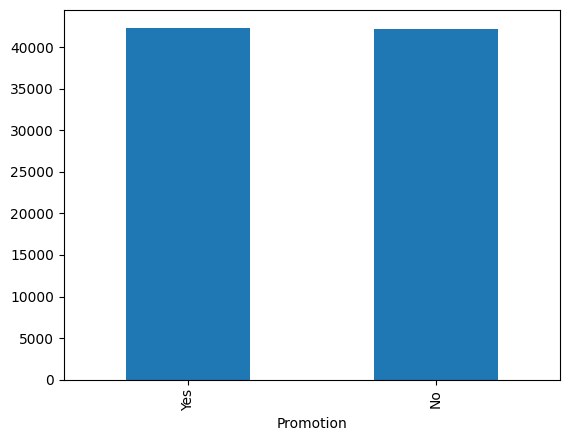

In [7]:
cnt_promote = train_data['Promotion'].value_counts()
train_data['Promotion'].value_counts().plot(kind='bar')
print(cnt_promote)

purchase
0    83494
1     1040
Name: count, dtype: int64


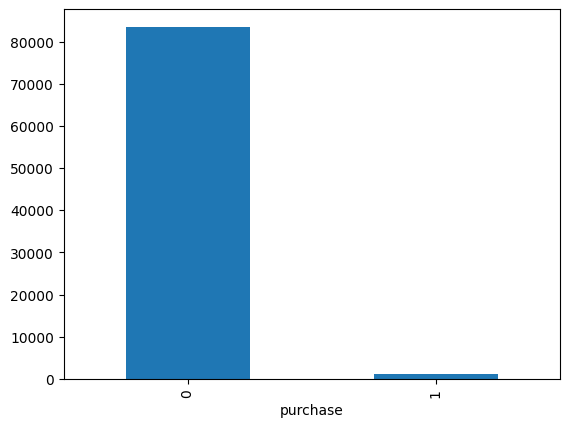

In [6]:
cnt_purchase = train_data['purchase'].value_counts()
train_data['purchase'].value_counts().plot(kind='bar')
print(cnt_purchase)

From the visualization we can indicate that:

* The sample size for promotion data is balanced
* The sample size for purchased data is imbalanced

We further check for (2)

### Invariant Metric

In [8]:
# Let's define the groups
n_treated_train = train_data[train_data['Promotion']=='Yes']['Promotion'].count()
n_non_treated_train = train_data[train_data['Promotion']=='No']['Promotion'].count()
n_purch_treat_train = train_data[(train_data['Promotion']=='Yes') & (train_data['purchase']==1)]['Promotion'].count()
n_purch_non_treat_train = train_data[(train_data['Promotion']=='No') & (train_data['purchase']==1)]['Promotion'].count()

In [9]:
# p_null value
p_null = n_purch_non_treat_train / n_non_treated_train
# standard error
se_null = np.sqrt(p_null * (1 - p_null) * (1/n_non_treated_train + 1/n_treated_train))

In [10]:
# z-score
z_train = ((n_purch_treat_train / n_treated_train) - p_null) / se_null
z_train

15.862830106831561

In [11]:
# P-value for the calculated z-score
p_val_train = 1 - stats.norm.cdf(z_train)
p_val_train

0.0

According to the z value we can claim the imbalance between purchase and non-purchase data.

### Check significance

To check whether this experiment is statistically significant, here we apply a 95% confidence interval to check between the experimental group and the control group.

- Null hypothesis: purchase rate of control group is also valid for the experiment group
- Alternative hypothesis: purchase rate for experiment group is bigger

In [12]:
# Purchase rate of the treated group
p_alt = n_purch_treat_train / n_treated_train
p_alt

0.017019167217448776

In [13]:
# Purchase rate of the control group
p_null = n_purch_non_treat_train / n_non_treated_train
p_null

0.007564619397676073

In [14]:
# Pooled proportion
p_pool = (n_purch_treat_train + n_purch_non_treat_train) / (n_treated_train + n_non_treated_train)
p_pool

0.012302742091939338

In [15]:
# Standard error
sse = np.sqrt(p_pool * (1 - p_pool) * ((1 / n_treated_train) + (1 / n_non_treated_train)))
sse

0.00075827775128664

In [16]:
# Z-score
z_score = (p_alt - p_null) / sse
z_score

12.468449461599388

The z score is unusually high, which indicates a p value close to 0. Therefore, we can reject null hypothesis, the experiment result is statistically significant.

### Indicators calculation

In [35]:
def IRR(n_purch_treat_train,n_treated_train,n_purch_non_treat_train,n_non_treated_train):
    return n_purch_treat_train / n_treated_train - n_purch_non_treat_train / n_non_treated_train
    
IRR(n_purch_treat_train,n_treated_train,n_purch_non_treat_train,n_non_treated_train)

0.009454547819772702

In [37]:
def NIR(n_purch_treat_train,n_treated_train,n_purch_non_treat_train):
    return (10 * n_purch_treat_train - 0.15 * n_treated_train) - 10 * n_purch_non_treat_train

NIR(n_purch_treat_train,n_treated_train,n_purch_non_treat_train)

-2334.5999999999995

Here we continue with task 2.

### EDA

As mentioned aboved, we need to find out promoted users who purchased, so we create a column to record these users, which also serve as the target column of our model.

In [19]:
# Creating target feature
train_data['target'] = train_data.apply(lambda x: x['Promotion'] == 'Yes' and x['purchase'] == 1, axis=1)
train_data['target'] = train_data['target'].map({True: 1, False: 0})

In [20]:
train_data['target'].value_counts()

target
0    83813
1      721
Name: count, dtype: int64

The data is very imbalance and might cause problems.

In [21]:
# Splitting into features (X) and target value (y)
y_train = train_data['target']
X_train = train_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]

### ML model construction

### SVC

In [22]:
model_svc = svm.SVC()
model_svc.fit(X_train, y_train)
pred_train = model_svc.predict(X_train)

print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     83813
           1       0.00      0.00      0.00       721

    accuracy                           0.99     84534
   macro avg       0.50      0.50      0.50     84534
weighted avg       0.98      0.99      0.99     84534



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

### Random Forest

In [24]:
model_rf = RandomForestClassifier(max_depth=2, random_state=0)
model_rf.fit(X_train, y_train)
pred_train_rf = model_rf.predict(X_train)
print(classification_report(y_train, pred_train_rf))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     83813
           1       0.00      0.00      0.00       721

    accuracy                           0.99     84534
   macro avg       0.50      0.50      0.50     84534
weighted avg       0.98      0.99      0.99     84534



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

We can see that for these two models, all scores for "purchase" is 0, therefore, the imbalance in the training data largely affect the training result. We can try tackle it. 

## Dealing with imbalance

### Upsampling

In [26]:
from sklearn.utils import resample

df_target_class = train_data[train_data['target']==1]
df_else_class = train_data[train_data['target']==0]

df_target_class_upsampled = resample(df_target_class,
                                    replace = True,
                                    n_samples = 83813,
                                    random_state = 123)

df_upsampled = pd.concat([df_else_class, df_target_class_upsampled])

df_upsampled['target'].value_counts()

target
0    83813
1    83813
Name: count, dtype: int64

Now, we have created to samples with the same size by adding ramdomly douplicated samples in the minority group. Continue and try with random forest.

In [30]:
x_upsampled = df_upsampled[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
y_upsampled = df_upsampled['target']

model_rf_ups = RandomForestClassifier(max_depth=2, random_state=0)
model_rf_ups.fit(x_upsampled, y_upsampled)
pred_rf_ups = model_rf_ups.predict(X_train)
print(classification_report(y_train, pred_rf_ups))

              precision    recall  f1-score   support

           0       1.00      0.41      0.58     83813
           1       0.01      0.84      0.02       721

    accuracy                           0.42     84534
   macro avg       0.50      0.63      0.30     84534
weighted avg       0.99      0.42      0.58     84534



### Downsampling

In [31]:
df_anybody_class_downsampled = resample(df_else_class,
                                       replace = False,
                                       n_samples = 721,
                                       random_state = 132)

df_downsampled = pd.concat([df_anybody_class_downsampled, df_target_class])

x_downsampled = df_downsampled[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
y_downsampled = df_downsampled['target']

model_rf_ds = RandomForestClassifier(max_depth=2, random_state=0)
model_rf_ds.fit(x_downsampled, y_downsampled)
pred_rf_ds = model_rf_ds.predict(X_train)
print(classification_report(y_train, pred_rf_ds))

              precision    recall  f1-score   support

           0       1.00      0.47      0.64     83813
           1       0.01      0.80      0.03       721

    accuracy                           0.47     84534
   macro avg       0.50      0.63      0.33     84534
weighted avg       0.99      0.47      0.63     84534



According to the aboved two methods, we can see that the recall and F1 score for both categories is low. Precision for positive class is extremely low without improvement. This better than before but still not a good approach

In [ ]:
from sklearn.metrics import roc_auc_score

prob_y_2 = model_rf_downs.predict_proba(X_train)